# Customer Churn Prediction — Modeling

This notebook covers model training, evaluation, and interpretation
based on features engineered in BigQuery and explored during EDA.

In [1]:
from google.cloud import bigquery
import pandas as pd

client = bigquery.Client()

query = """
SELECT *
FROM `churn_analytics.customer_features`
"""

df = client.query(query).to_dataframe()

d:\Python\PythonCode\venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [2]:
y = df["churn_flag"]

X = df.drop(columns=["churn_flag", "customer_id"])

In [3]:
X = pd.get_dummies(X, drop_first=True)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Handling Missing Values

When trying to fit the model, some 'NaN' values (the NULLs coming from BigQuery) were avoiding the model from running properly (LogisticRegression can't handle NaN values).

Missing values are gonna be imputed using the median strategy prior to model training.

In [5]:
X.isna().sum().sort_values(ascending=False).head(10)

total_charges        11
avg_monthly_spend    11
is_male               0
has_dependents        0
tenure                0
phone_service         0
multiple_lines        0
internet_service      0
online_security       0
senior_citizen        0
dtype: int64

In [6]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_imputed, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [8]:
feature_names = X_train.columns

coef_df = pd.Series(
    log_reg.coef_[0],
    index=feature_names
).sort_values(key=abs, ascending=False)

coef_df.head(30)

contract_Two year                        -1.348746
phone_service                            -0.929515
tenure_group_4+_years                     0.674166
contract_One year                        -0.671435
multiple_lines                            0.403188
payment_method_Electronic check           0.356686
paperless_billing                         0.327159
tenure_group_1-2_years                   -0.289077
service_count                            -0.274580
internet_service                          0.274039
online_security                          -0.270306
tech_support                             -0.211342
streaming_movies                          0.188492
senior_citizen                            0.175648
streaming_tv                              0.174891
device_protection                         0.145311
has_dependents                           -0.122347
payment_method_Mailed check              -0.109198
tenure_group_2-4_years                    0.089996
payment_method_Credit card (aut

The coefficients show that having a two-year contract has the strongest effect in reducing churn, followed by having phone service and a one-year contract.

Conversely, after controlling for other features, being in the 4+ years tenure group is associated with a higher likelihood of churn compared to customers in the 0–1 year tenure group.

In [9]:
y_pred = log_reg.predict(X_test_imputed)
y_prob = log_reg.predict_proba(X_test_imputed)[:, 1]

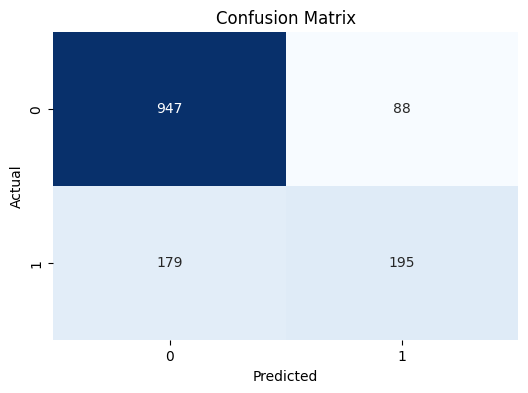

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88      1035
         1.0       0.69      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC: 0.853831150378465


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

### Model Insights

* **Imbalanced classes:** More non-churners than churners.
* **Non-churners (0.0):** High precision, recall, F1 → predicted well.
* **Churners (1.0):** Lower precision, recall, F1 → model struggles.
* **Accuracy:** High, closer to non-churner F1 → dominated by majority class.
* **Macro vs. weighted F1:** Macro shows balanced performance; weighted favors majority.
* **Overall:** Good at non-churners, needs improvement on churners.

Since churners are the critical class, the key is to catch as many of them as possible, which means improving recall for class 1.0 (churners), even if it slightly lowers precision or overall accuracy.

Some potential adjustments are:

  - Adjusting the decision threshold lower than 0.5 to be more sensitive to churners.
  - Using class weighting or resampling to give churners more importance during training.
  - Trying models or techniques that focus on minority class performance.

Recall for churners is the main metric to optimize here.

